# Amazon Fine Food Reviews Analysis

## size of dataset:568454 rows and 10 columns
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

Id
ProductId - unique identifier for the product
UserId - unqiue identifier for the user
ProfileName
HelpfulnessNumerator - number of users who found the review helpful
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
Score - rating between 1 and 5
Time - timestamp for the review
Summary - brief summary of the review
Text - text of the review
Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# lets import some necessary libraries

In [58]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
## now lets make a connection with our sql database and load the data
conn = sqlite3.connect('database.sqlite')
data = pd.read_sql_query('''SELECT * FROM REVIEWS''',conn)
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


## life cycle of a machine learning project
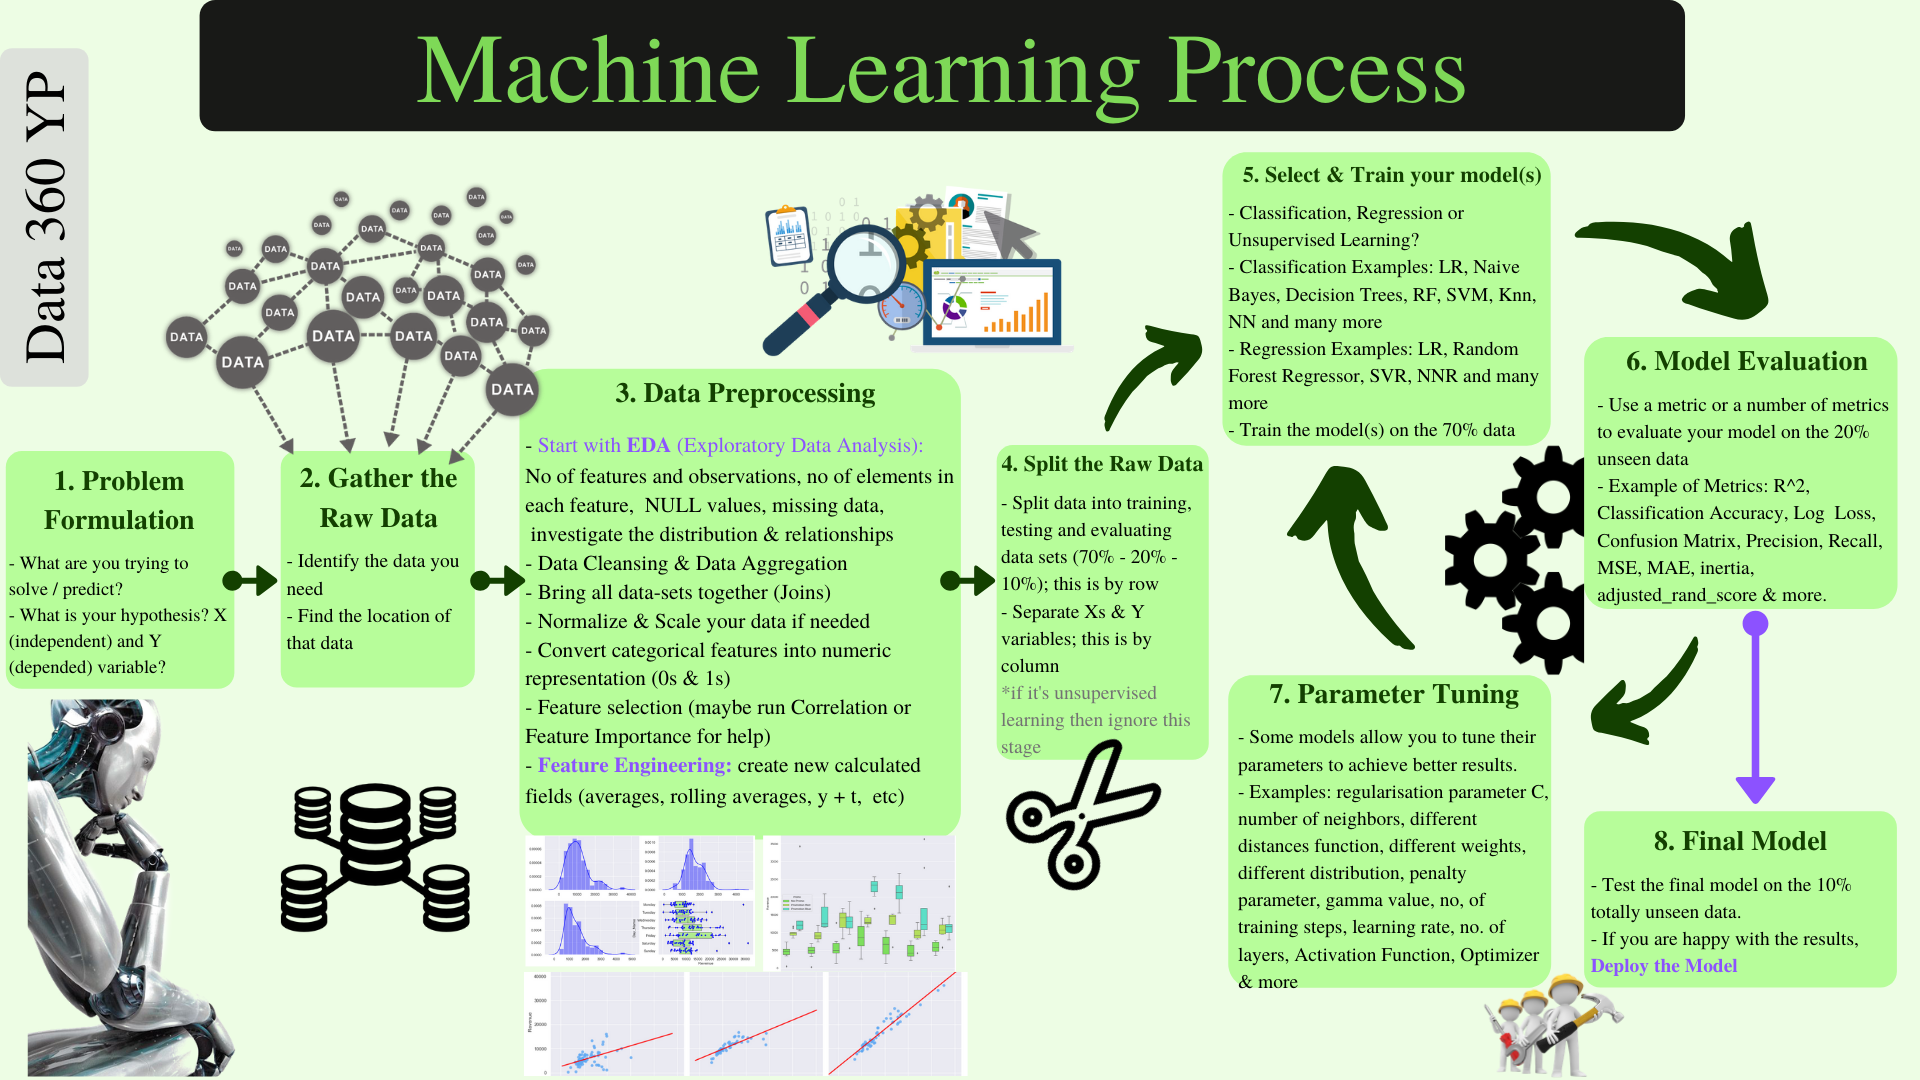

# step1:problem formulation and raw data processing

### After i made a clean observation i figured out we can use the score column as our label for our separation purpose of model 

In [3]:
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### for our simplicity lets consider all the data with score greater than 3 is a positive review and less than 3 as negative and lets filter score equal to 3 from our data

### * before doing so lets handle with null values

In [4]:
for feature in data.columns:
    print("{} has {} values".format(feature,data[feature].isnull().sum()))

Id has 0 values
ProductId has 0 values
UserId has 0 values
ProfileName has 0 values
HelpfulnessNumerator has 0 values
HelpfulnessDenominator has 0 values
Score has 0 values
Time has 0 values
Summary has 0 values
Text has 0 values


## we can clearly observe that there are no values in our dataset

* so lets have a brief diuscussion about our features
1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

## now lets filter our score column

In [5]:
data1 = pd.read_sql_query('''SELECT * FROM REVIEWS WHERE Score!=3''',conn)
data1.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
print("data before filtering has {} rows and {} columns".format(data.shape[0],data.shape[1]))
print("****************************************************************************************")
print("data before filtering has {} rows and {} columns".format(data1.shape[0],data1.shape[1]))

data before filtering has 568454 rows and 10 columns
****************************************************************************************
data before filtering has 525814 rows and 10 columns


## lets convert the values in score column into positive and negative values

In [7]:
def convertion(x):
    if x >= 3:
        return "positive"
    else:
         return "negative"
        
actual_score = data1["Score"]
filtered_data = actual_score.map(convertion)
data1["Score"] = filtered_data

In [8]:
data1.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## we can observe that our data in Score column is converted

# Step2:Data preprocessing

In [9]:
for feature in data1.columns:
    print("no of unique features in {} is {}".format(feature,data[feature].nunique()))

no of unique features in Id is 568454
no of unique features in ProductId is 74258
no of unique features in UserId is 256059
no of unique features in ProfileName is 218418
no of unique features in HelpfulnessNumerator is 231
no of unique features in HelpfulnessDenominator is 234
no of unique features in Score is 5
no of unique features in Time is 3168
no of unique features in Summary is 295744
no of unique features in Text is 393579


## now lets see the count of reviews which are positive and which are negative


In [10]:
data1_positive = pd.read_sql_query('''SELECT * FROM REVIEWS WHERE SCORE > 3
                                       ORDER BY profileName,UserID 
''',conn)
data1_positive.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,136277,B000W4OQRW,ABCOLENOSM0IQ,,2,2,5,1232841600,great taste !!!,If I would have known this snack would be so g...
1,241773,B0081XPTBS,A2JKR0W0EQ6QQM,,0,2,5,1334966400,good formula!!,this formula can help baby happy every day<br ...
2,358219,B0032CJPOK,A2JKR0W0EQ6QQM,,0,2,5,1334966400,good formula!!,this formula can help baby happy every day<br ...
3,35173,B001ATMQK2,AD67UXV6RV1CV,,1,1,5,1317427200,SO GOOD!,This sauce is so good! Ordered it and it arriv...
4,172867,B000FAIRCI,A2NY8YRUTRWB0Y,:Jury Duty:,3,4,4,1268784000,Should not have to search all over the interne...,"After a 20 minute web search, here are the ing..."
5,526101,B000162MSQ,A2NY8YRUTRWB0Y,:Jury Duty:,3,3,5,1246060800,Oh. My. Goodness.,These are the best chocolate chip cookies I've...
6,564997,B000LKVT90,A2NY8YRUTRWB0Y,:Jury Duty:,6,6,5,1247097600,Great Organic Beans,I've always loved baked beans since I was litt...
7,5386,B000H27K86,A1ER6IYOMM8VCT,"! MR. KNOW IT ALL ;-b ""DR SHOCK""",0,0,5,1199491200,"A TASTE OF ""N'AW'INS"" GREAT SPICE MIX FOR MANY...",I have been using this spice mix for many year...
8,55589,B004CYLW7A,A1ER6IYOMM8VCT,"! MR. KNOW IT ALL ;-b ""DR SHOCK""",2,2,4,1297900800,"TASTY, BUT NOTHING NEW!",I enjoy cereal and this cereal is like most su...
9,231983,B002RSVOLM,A1ER6IYOMM8VCT,"! MR. KNOW IT ALL ;-b ""DR SHOCK""",1,1,5,1269648000,SIMPLY AMAZING!,I am the biggest skeptic when it comes to fads...


### AS we can see in the case of user 	A2JKR0W0EQ6QQM we can see duplicate reviews but we have different product id dont it look strange but the problem is a mini secret in amazon.

###  we have seen different models of a product we are buying example a thsirt may have diiferent colors on same models all the colors have diiferent product ids but the review given to a particular color goes to all colors lets understand this with a live example

### https://www.amazon.com/dp/B0081XPTBS if we refer this link you find a pic like this

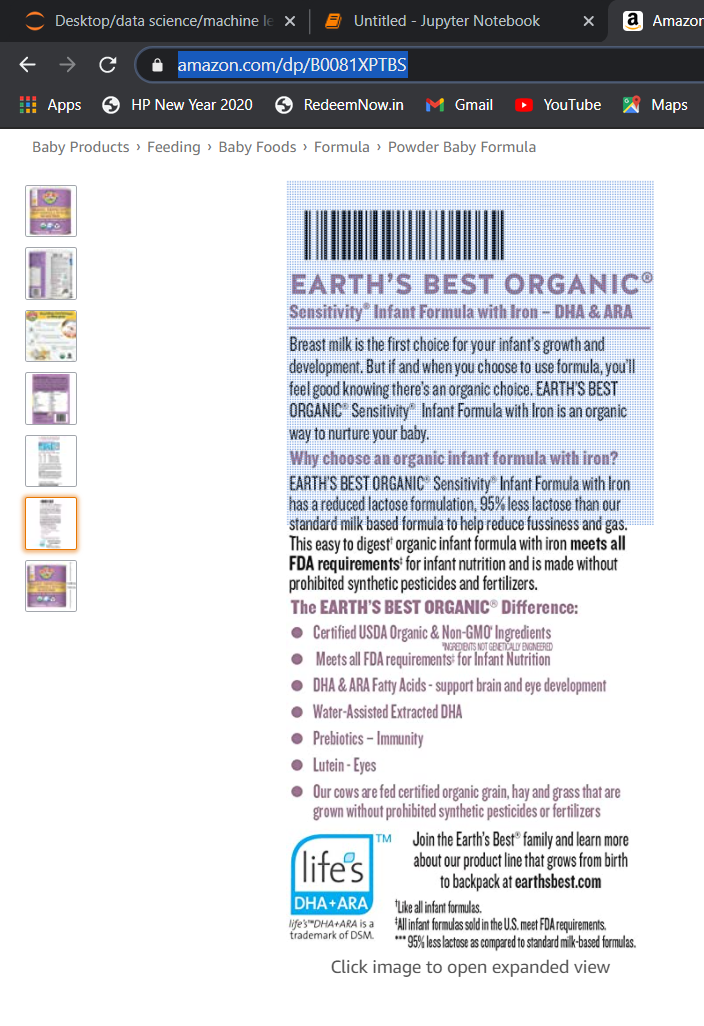

## we can many similar products there given a review to a product all the products get that review

### when i queried across the data i even found this problem

In [11]:
cleaned_data = pd.read_sql_query('''SELECT * FROM REVIEWS WHERE HelpfulnessNumerator>HelpfulnessDenominator''',conn)
cleaned_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


### we know that HelpfulnessNumerator must always be less than HelpfulnessDenominator abd these are errors made due to some kind of problem so its better to remove it from our data so it wont effect our model

## as now we have found many problems in data lets make a cleaned make a cleaned DataFrame free of those problems so we can feed it for our machine learning model 

In [12]:
cleaned_data = pd.read_sql_query('''SELECT DISTINCT * FROM REVIEWS WHERE HelpfulnessDenominator>HelpfulnessNumerator''',conn)
cleaned_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
1,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,5,1262044800,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...
2,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan..."
3,28,B001GVISJM,AAAS38B98HMIK,Heather Dube,0,1,4,1331856000,Great Bargain for the Price,I was so glad Amazon carried these batteries. ...
4,32,B003F6UO7K,A31OQO709M20Y7,"Molly V. Smith ""staral""",0,1,5,1288310400,THIS IS MY TASTE...,"This offer is a great price and a great taste,..."


In [13]:
print("the Data Frame has {} rows and {} columns".format(cleaned_data.shape[0],cleaned_data.shape[1]))

the Data Frame has 115091 rows and 10 columns


## so lets convert our score column

In [14]:
def convertion(x):
    if x >= 3:
        return "positive"
    else:
         return "negative"
        
actual_score = cleaned_data["Score"]
filtered_data = actual_score.map(convertion)
cleaned_data["Score"] = filtered_data

In [15]:
cleaned_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,positive,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
1,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,positive,1262044800,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...
2,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,negative,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan..."


In [16]:
positive_count = cleaned_data[cleaned_data["Score"] == "positive"]
negative_count = cleaned_data[cleaned_data["Score"] == "negative"]
print("the shape of positive count is",positive_count.shape)
print("the shape of negative count is",negative_count.shape)

the shape of positive count is (72351, 10)
the shape of negative count is (42740, 10)


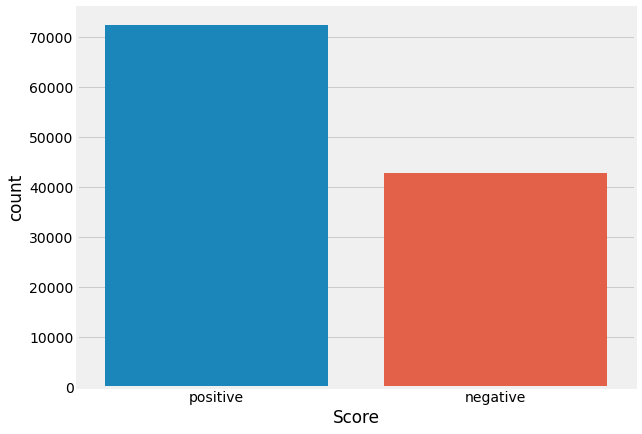

In [17]:
plt.figure(figsize=[10,7])
plt.style.use('fivethirtyeight')
sn.countplot(x="Score",
    y=None,
    hue=None,
    data=cleaned_data,
    order=None,
    hue_order=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    dodge=True,
    ax=None)
plt.show()

<Figure size 720x576 with 0 Axes>

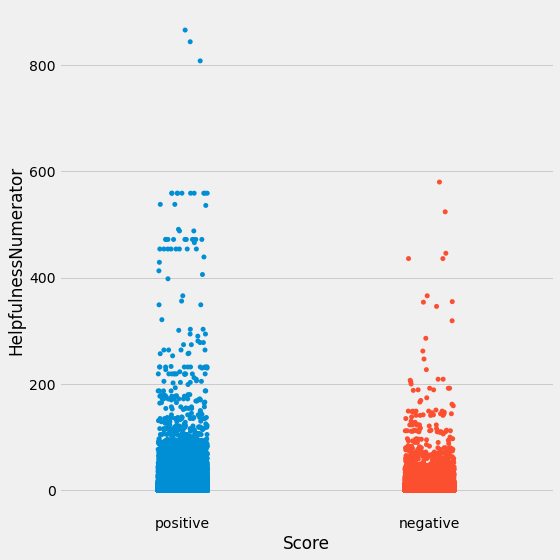

In [18]:
plt.figure(figsize=[10,8])
sn.catplot(x="Score",
    y="HelpfulnessNumerator",
    hue=None,
    data=cleaned_data,
    row=None,
    col=None,
    col_wrap=None,
    ci=95,
    n_boot=1000,
    units=None,
    seed=None,
    order=None,
    hue_order=None,
    row_order=None,
    col_order=None,
    kind='strip',
    height=8,
    aspect=1,
    orient=None,
    color=None,
    palette=None,
    legend=True,
    legend_out=True,
    sharex=True,
    sharey=True,
    margin_titles=False,
    facet_kws=None)
plt.show()

## we can clearly see that helpfulness numerator goes up for positive reviews

<Figure size 720x576 with 0 Axes>

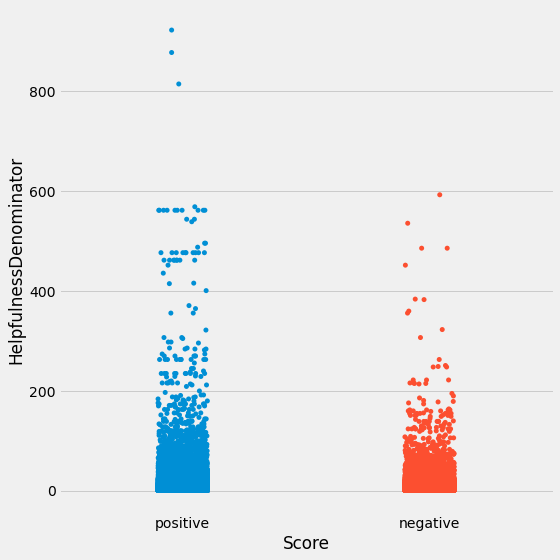

In [19]:
plt.figure(figsize=[10,8])
sn.catplot(x="Score",
    y="HelpfulnessDenominator",
    hue=None,
    data=cleaned_data,
    row=None,
    col=None,
    col_wrap=None,
    ci=95,
    n_boot=1000,
    units=None,
    seed=None,
    order=None,
    hue_order=None,
    row_order=None,
    col_order=None,
    kind='strip',
    height=8,
    aspect=1,
    orient=None,
    color=None,
    palette=None,
    legend=True,
    legend_out=True,
    sharex=True,
    sharey=True,
    margin_titles=False,
    facet_kws=None)
plt.show()

# lets start the text mining process from now

# why text mining?

### machine learning algorithms can only handle numerical data but not text data so we convert the text data into numerical vectors so our model can use them to feed.

## steps of text mining:
1. remove html attributes and symbols
2. remove punctuations
3. convert to lower
4. remove stopwords

In [20]:
cleaned_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,positive,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
1,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,positive,1262044800,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...


### we can clearly say that id,productid,userid,profilename doesnt play a much role in buliding our model so lets drop them but before that lets see the algorithm which will best suit our model

In [21]:
cleaned_data["Score"] = np.where(cleaned_data["Score"]=="positive",1,0)

In [22]:
cleaned_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,1,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
1,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,1,1262044800,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...
2,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,0,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan..."
3,28,B001GVISJM,AAAS38B98HMIK,Heather Dube,0,1,1,1331856000,Great Bargain for the Price,I was so glad Amazon carried these batteries. ...
4,32,B003F6UO7K,A31OQO709M20Y7,"Molly V. Smith ""staral""",0,1,1,1288310400,THIS IS MY TASTE...,"This offer is a great price and a great taste,..."


In [48]:
cleaned_data.shape

(115091, 10)

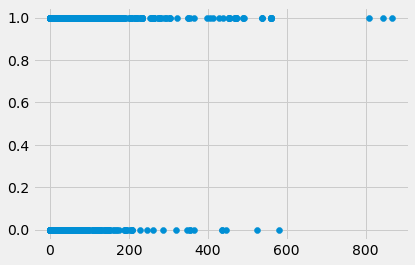

In [23]:
plt.scatter(cleaned_data['HelpfulnessNumerator'],cleaned_data['Score'])

In [24]:
df = cleaned_data.drop(['Id','ProductId','UserId','ProfileName','Summary'],axis=1)
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text
0,4,5,1,1268352000,The Strawberry Twizzlers are my guilty pleasur...
1,4,5,1,1262044800,My daughter loves twizzlers and this shipment ...
2,0,1,0,1332633600,"The candy is just red , No flavor . Just plan..."
3,0,1,1,1331856000,I was so glad Amazon carried these batteries. ...
4,0,1,1,1288310400,"This offer is a great price and a great taste,..."


In [25]:
df["Text"][1]

"My daughter loves twizzlers and this shipment of six pounds really hit the spot. It's exactly what you would expect...six packages of strawberry twizzlers."

## so new lets perform the steps of text mining on text column and convert them into a vectors using term frequency technique

In [26]:
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in tqdm(range(0, len(df))):
    review = re.sub('[^a-zA-Z]', ' ', df['Text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

100%|██████████████████████████████████████████████████████████████████████████| 115091/115091 [49:46<00:00, 38.54it/s]


In [27]:
corpus[1]

'daughter love twizzler shipment six pound realli hit spot exactli would expect six packag strawberri twizzler'

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
tf_idf = CountVectorizer(ngram_range=(1,2),max_features=1000)
matrix = tf_idf.fit_transform(corpus)

In [43]:
matrix = matrix.toarray()

In [45]:
matrix.shape

(115091, 1000)

In [47]:
values = pd.DataFrame(matrix)
values.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# we can observe that we conerted our text into vectors

In [61]:
data = pd.concat([values,df.drop("Text",axis=1)],axis=1)

In [62]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,4,5,1,1268352000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,5,1,1262044800
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1332633600
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1331856000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1288310400


## now our dataset is ready for our model

# step4:Model building
### lets split the data

In [63]:
x = data.drop("Score",axis=1)
y = data["Score"]
print(x.shape)
print(y.shape)

(115091, 1003)
(115091,)


In [64]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=10,test_size=0.3)

In [65]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(80563, 1003)
(34528, 1003)
(80563,)
(34528,)


## model building

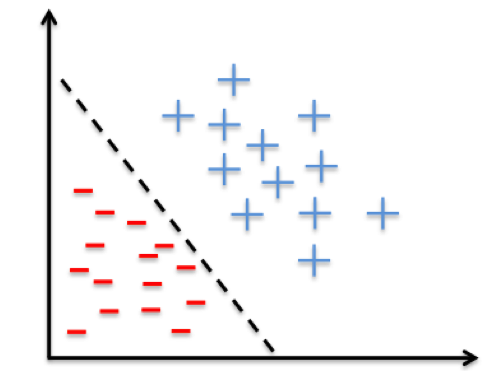

# lets use a classification algorithm

In [66]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(x_train,y_train)

KNeighborsClassifier()

In [68]:
model.score(x_train,y_train)

0.8135868823157032

In [69]:
model.score(x_test,y_test)

0.7274386005560705

In [ ]:
import tqdm as tqdm
values = []
train_score = []
test_score = []
for i in range(1,25):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(x_train,y_train)
    train_score.append(model.score(x_train,y_train))
    test_score.append(model.score(x_test,y_test))
    values.append(i)